In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import models
import util
import os
import config
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns
import face_recognition
import dlib
from PIL import Image
from skimage import io
import scipy.misc
import matplotlib.pyplot as plt

# crop and detect faces in real ims

In [18]:
def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

# Load image
def crop_and_resize_ims(dir_base='../data/pilot-our-images/',
                        dir_out_base='../data_processed/pilot-our-images-large',
                        MULT = 1.6):
    for folder in os.listdir(dir_base):
        dir_in = oj(dir_base, folder)
        dir_out = oj(dir_out_base, folder)
        os.makedirs(dir_out, exist_ok=True)

        im_num = 0
        for fname in sorted(os.listdir(dir_in)):
            if '.jpg' in fname:
                img_path = oj(dir_in, fname)
                image = io.imread(img_path)

                # Detect faces
                detected_faces = detect_faces(image)
                if len(detected_faces) > 0:

                    # Crop faces and plot
                    (left, upper, right, lower) = detected_faces[0]
                    
                    mid = (left + right) // 2
                    diff = (mid - left) * MULT
                    left = mid - diff
                    right = mid + diff
                    
                    mid = (lower + upper) // 2
                    diff = (mid - lower) * MULT
                    upper = mid + diff
                    lower = mid - diff                   

                    im_face = Image.fromarray(image).crop((left, upper, right, lower))
                    dim_min = min(im_face.width, im_face.height)
                    im_face = im_face.crop((0, 0, dim_min, dim_min)) # im_face[:dim_min, :dim_min]
                    im_face = im_face.resize((1024, 1024))
                    
                    '''
                    util.imshow(np.asarray(im_face))
                    plt.show()
                    '''

                    
                    # save
                    out_fname = oj(dir_out, f'{folder}_{im_num:03d}.jpg')
                    im_face.save(out_fname)
                    im_num += 1

crop_and_resize_ims()        

# lower res ims

In [2]:
sys.path.append('stylegan2encoder')

In [3]:
N_IMS = 100
out_dir = ''
for fname in sorted(os.listdir(config.DIR_CELEBA_IMS))[N_IMS]:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-3-6c5bf0f42175>, line 4)

In [4]:
import projector
import pretrained_networks
import project_images

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/pyt

In [12]:
network_pkl='gdrive:networks/stylegan2-ffhq-config-f.pkl'
vgg16_pkl='https://drive.google.com/uc?id=1N2-m9qszOeVC9Tq77WxsLnuWwOedQiD2'
num_steps=300
initial_learning_rate=0.1
initial_noise_factor=0.05
verbose=False
regularize_mean_deviation_weight=0.1
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

In [13]:
print('Loading networks from "%s"...' % network_pkl)

proj = projector.Projector(
    vgg16_pkl             = vgg16_pkl,
    num_steps             = num_steps,
    initial_learning_rate = initial_learning_rate,
    initial_noise_factor  = initial_noise_factor,
    verbose               = verbose,
    regularize_mean_deviation_weight = regularize_mean_deviation_weight
)
proj.set_network(Gs)

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...


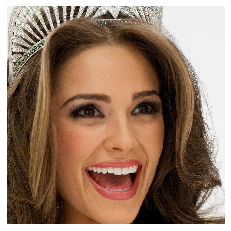

In [14]:
fname = oj(config.DIR_CELEBA_IMS, '00001.jpg')
im = mpimg.imread(fname)
util.imshow(im)

In [ ]:
latents, im_rec = project_images.project_image(proj, src_file=fname, dst_dir=None, tmp_dir='tmp', video=False)

Loading images from "tmp/dataset/images"
Creating dataset "tmp/dataset/tfrecords"
Added 1 image.                          
Projecting image "00001.jpg"...
299 / 300 ... 

In [ ]:
util.imshow(im_rec)